In [1]:
import pandas as pd
import numpy as np
from lightgbm.sklearn import LGBMClassifier

In [2]:
df = pd.read_csv('data_steven_anon.csv')

In [3]:
input_features = (['dem_pat_age_at_inclusion', 'dem_pat_gender', 'dem_pat_BMI'] 
                    + list(df.columns[df.columns.str.startswith('med_hist')].values)
                    + list(df.columns[df.columns.str.startswith('adm') & ~df.columns.isin(['adm_date', 'adm_dept', 'adm_hosp_date'])].values))

In [4]:
X = df[input_features]
y = df['COVID_and_prob_and_pos']

In [5]:
from sklearn.base import TransformerMixin
class ColumnImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.options = {col: X[col].dropna().values for col in X.columns}
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in X.columns:
            if len(self.options[col]) > 0:
                X.loc[X[col].isna(), col] = np.random.choice(self.options[col], size=X[col].isna().sum())
        return X

In [34]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
def plot_shapley(clfs, X_unimputed):
    clf_shaps = []
    for name, n, clf, X in clfs:
        explainer = shap.TreeExplainer(clf)
        s = len(X)//n
        print(s, n, len(X))
        shaps = []
        for i in tqdm(range(n)):
            shaps.append(explainer.shap_values(X.iloc[s*i:s*(i+1), :])[1])
        print(np.array(shaps).shape)
        shaps = np.mean(shaps, axis=0)
        print(shaps.shape, X.shape)
        shap.summary_plot(shaps, features=X_unimputed)
        clf_shaps.append(pd.DataFrame({'model': name, 'missing': X_unimputed.isna().values.ravel(), 'value': shaps.ravel()}))

    clf_shaps = pd.concat(clf_shaps)
    
    plt.figure(figsize=(14, 5))
    sns.kdeplot(data=clf_shaps[clf_shaps.missing], x='value', hue='model', common_norm=False)
    plt.title('Missing shaps')
    plt.xlim(-2, 2)
    
    plt.figure(figsize=(14, 5))
    sns.kdeplot(data=clf_shaps[~clf_shaps.missing], x='value', hue='model', common_norm=False)
    plt.title('Present shaps')
    plt.xlim(-2, 2)
    
    plt.figure()
    sns.barplot(data=clf_shaps, x='model', y='value', hue='missing', estimator=lambda x: np.abs(x).mean())
#     sns.kdeplot((X.isna() * shaps).values.ravel(), label='missing')
#     sns.kdeplot(((1-X.isna()) * shaps).values.ravel(), label='present')
#     plt.legend()


In [7]:
clf1 = LGBMClassifier(n_jobs=-1)
clf1.fit(X, y)

LGBMClassifier()

In [16]:
plot_shapley(clf, X, 1)

NameError: name 'clf' is not defined

In [44]:
from tqdm import tqdm
def repeated_impute(X, y, imputer, should_fit, n=100):
    X_rep = []
    y_rep = []
    
    if should_fit:
        imputer.fit(X)
        
    for i in tqdm(range(n)):
        X_rep.append(imputer.transform(X))
        y_rep.append(y)
    
    X_rep = pd.concat([pd.DataFrame(x) for x in X_rep])
    y_rep = pd.concat(y_rep)
    return X_rep, y_rep

In [41]:
from sklearn.pipeline import make_pipeline
clf2 = LGBMClassifier(n_jobs=-1)
X_rep, y_rep = repeated_impute(X, ColumnImputer(), should_fit=True, n=500)
clf2.fit(X_rep, y_rep)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 104.45it/s]


LGBMClassifier()

In [42]:
from sklearn.pipeline import make_pipeline
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
clf3 = LGBMClassifier(n_jobs=-1)
X_rep2, y_rep2 = repeated_impute(X, IterativeImputer(sample_posterior=True), should_fit=True, n=80)
clf3.fit(X_rep2, y_rep2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:52<00:00,  1.51it/s]


LGBMClassifier()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]

434 1 434
(1, 434, 26)
(434, 26) (434, 26)


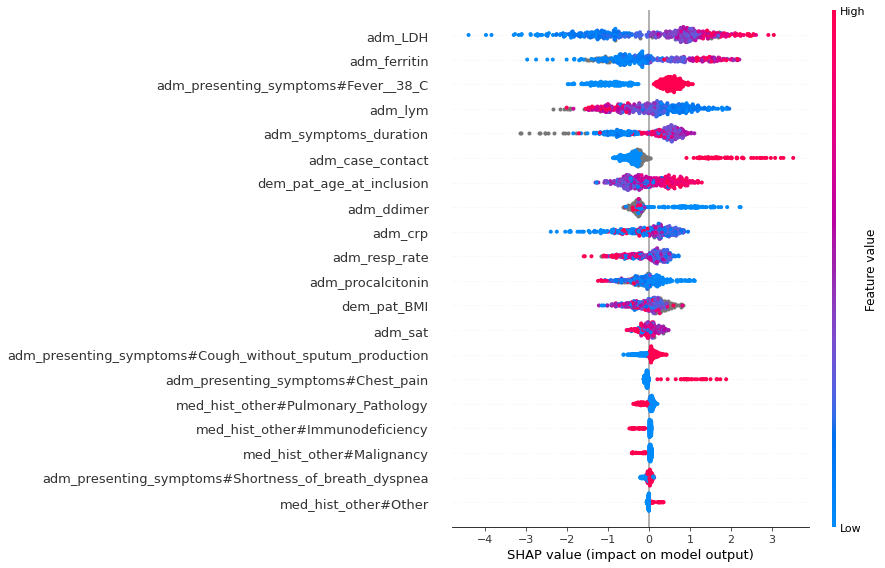

  1%|▌                                                                                                | 3/500 [00:00<00:21, 22.90it/s]

434 500 217000


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.21it/s]


(500, 434, 26)
(434, 26) (217000, 26)


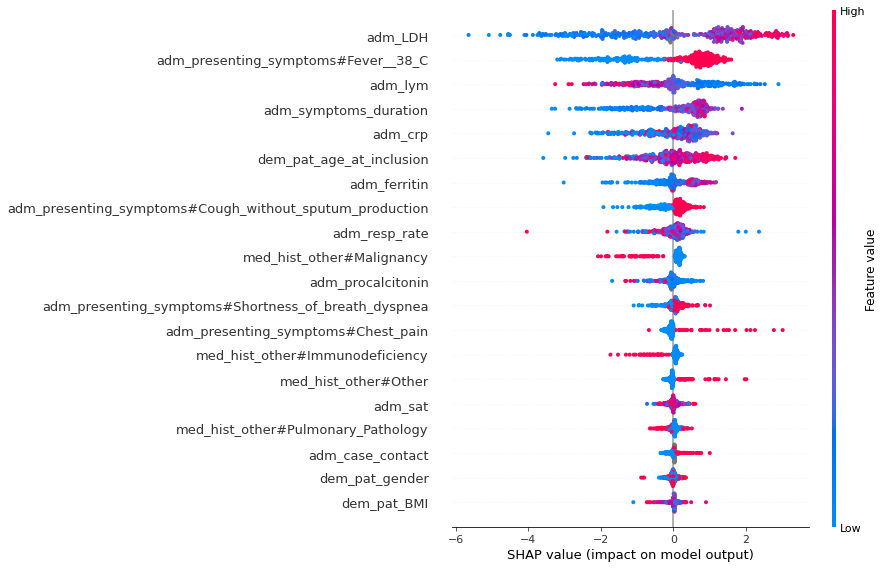

  4%|███▋                                                                                              | 3/80 [00:00<00:02, 26.09it/s]

434 80 34720


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 23.83it/s]


(80, 434, 26)
(434, 26) (34720, 26)


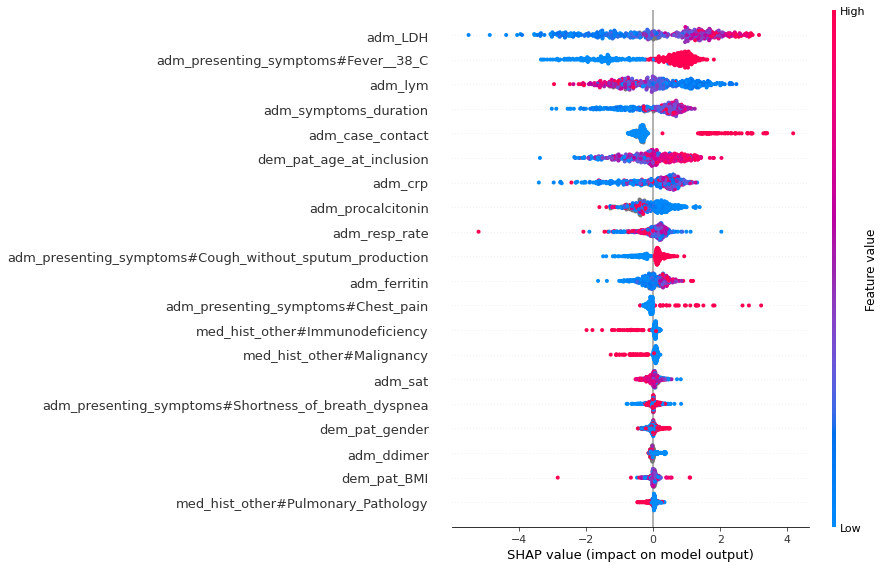

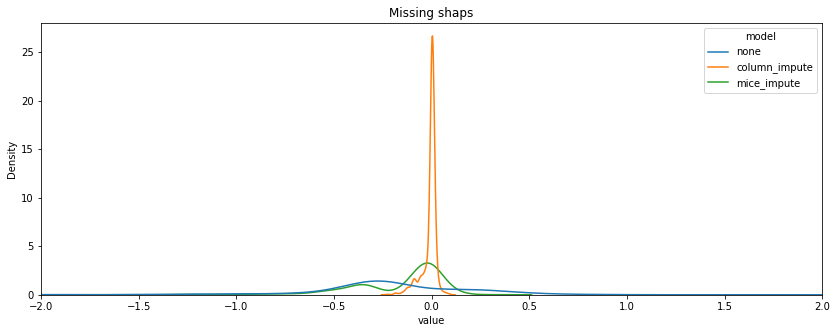

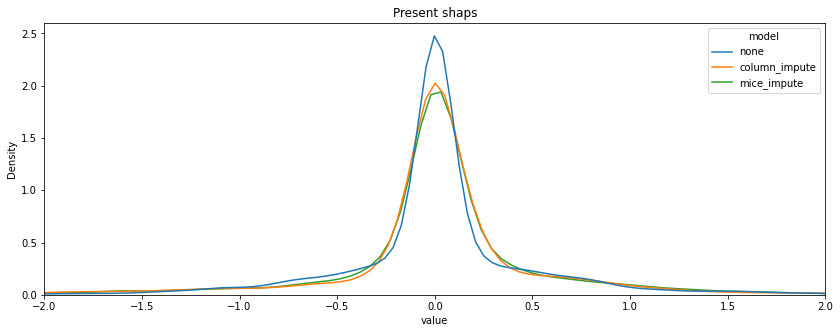

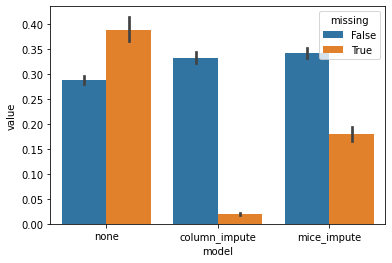

In [43]:
plot_shapley([
    ('none', 1, clf1, X), 
    ('column_impute', 500, clf2, X_rep), 
    ('mice_impute', 80, clf3, X_rep2)
], X)

In [67]:
from sklearn.metrics import roc_auc_score
def plot_performance(clf, imputers, X_train, y_train, X_test, y_test):
    clfs = []
    scores = []
    for name, n, imputer in imputers:
        X_rep, y_rep = repeated_impute(X_train, y_train, imputer, should_fit=True, n=n) if imputer is not None else (X_train, y_train)
        clf.fit(X_rep, y_rep)
        X_rep, y_rep = repeated_impute(X_test, y_test, imputer, should_fit=False, n=n) if imputer is not None else (X_test, y_test)
        s = len(X_test)
        preds = []
        for i in tqdm(range(n)):
#             print(s*i, s*(i+1))
#             print(X_rep.iloc[s*i:s*(i+1), :].shape)
#             print(clf.predict_proba(X_rep.iloc[s*i:s*(i+1), :]).shape)
#             print(clf.predict_proba(X_rep.iloc[s*i:s*(i+1), :])[:, 1].shape)
            preds.append(clf.predict_proba(X_rep.iloc[s*i:s*(i+1), :])[:, 1])
#         print(np.array(preds).shape)
        preds = np.mean(preds, axis=0)
        scores.append({'model': name, 'score': roc_auc_score(y_test, preds)})
    
    sns.barplot(data=pd.DataFrame(scores), x='model', y='score')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 634.93it/s]


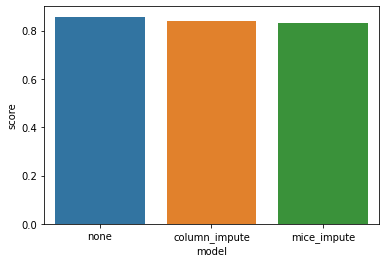

In [68]:
plot_performance(LGBMClassifier(n_jobs=-1), [
    ('none', 1, None), 
    ('column_impute', 500, ColumnImputer()), 
    ('mice_impute', 80, IterativeImputer(sample_posterior=True))
], X[df.institute_abbreviation == 'RUNMC'], y[df.institute_abbreviation == 'RUNMC'], 
    X[df.institute_abbreviation != 'RUNMC'], y[df.institute_abbreviation != 'RUNMC'])